In [519]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

## Import du csv

path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "tgv_data.csv")

df = pd.read_csv(path, delimiter=';')
df = df.reset_index(drop=True)



### Création des mois et années en features

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['mois'] = df['date'].dt.month
df['annee'] = df['date'].dt.year
#df.set_index('date', inplace=True)  



######## Typologie des features


## Les X qu'on a

# Ce qu'on aura pour prédire le future (attention à durée moyenne)
list_feature = ['annee','mois',
'gare_depart','gare_arrivee','service',
'duree_moyenne']


### Les Y à prédire

# Les Causes en %
list_prct_cause = ['prct_cause_externe',
'prct_cause_infra',
'prct_cause_gestion_trafic',
'prct_cause_materiel_roulant',
'prct_cause_gestion_gare',
'prct_cause_prise_en_charge_voyageurs']

# La Durée du retard
list_retard = ['retard_moyen_tous_trains_arrivee',
'retard_moyen_depart',
'retard_moyen_trains_retard_sup15',
'retard_moyen_arrivee']
#,'retard_moyen_tous_tests_depart']

# Le nombre de test en retard
list_nbr_test_en_retard = [
'nb_train_prevu',
'nb_annulation',
'nb_train_depart_retard',
'nb_train_retard_arrivee',
'nb_train_retard_sup_15',
'nb_train_retard_sup_30',
'nb_train_retard_sup_60']

cols = list_feature + list_retard

df_init = df
df = df[cols]


## Test d'un modèle uniquement sur Lyon -> Paris

In [315]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Condition Paris -> Lyon
df_pl = df[(df['gare_depart']== 'LYON PART DIEU') & (df['gare_arrivee']=='PARIS LYON')]

## One Hot Encoding des features catégorielles
columns_to_encode = ['annee', 'mois', 'gare_depart', 'gare_arrivee', 'service']
df_pl_encoded = pd.get_dummies(df_pl, columns=columns_to_encode)

## Split en Train = 2018 et 2019 et Test = 2020
train_data = df_pl_encoded[(df_pl_encoded.annee_2018 == 1) | (df_pl_encoded.annee_2019 == 1)]
test_data = df_pl_encoded[df_pl_encoded.annee_2020 == 1]


#Pour l'instant on prédit juste le retard moyen à l'arrivée
list_retard = ['retard_moyen_arrivee']
#Split en X et y
X_train = train_data.drop(columns=['retard_moyen_tous_trains_arrivee', 'retard_moyen_depart', 'retard_moyen_trains_retard_sup15','retard_moyen_arrivee'])
y_train = train_data[['retard_moyen_tous_trains_arrivee']]

X_test = test_data.drop(columns=['retard_moyen_tous_trains_arrivee', 'retard_moyen_depart', 'retard_moyen_trains_retard_sup15','retard_moyen_arrivee'])
y_test = test_data[['retard_moyen_tous_trains_arrivee']]

#X_train = train_data[list_feature]
#y_train = train_data[list_retard]

#X_test = test_data[list_feature]
#y_test = test_data[list_retard]


In [316]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

57.806729717716735

## Encodage basé sur le target des données catégorielles

In [317]:
#df_retard = df.groupby('gare_depart').retard_moyen_arrivee.std()
#df_retard.sort_values(ascending=False)
#plt.hist(df[df.gare_depart == 'TOURCOING'].retard_moyen_arrivee)

In [323]:

# Calculer la moyenne du retard pour chaque gare de départ
mean_retard_by_gare_depart = df.groupby('gare_depart')['retard_moyen_arrivee'].mean()
mean_retard_by_gare_arrivee = df.groupby('gare_arrivee')['retard_moyen_arrivee'].mean()
mean_retard_by_mois = df.groupby('mois')['retard_moyen_arrivee'].mean()
mean_retard_by_annee = df.groupby('annee')['retard_moyen_arrivee'].mean()

# Effectuer l'encodage basé sur le target
df['gare_depart_encoded'] = df['gare_depart'].map(mean_retard_by_gare_depart)
df['gare_arrivee_encoded'] = df['gare_arrivee'].map(mean_retard_by_gare_arrivee)
df['mois_encoded'] = df['mois'].map(mean_retard_by_mois)
df['annee_encoded'] = df['annee'].map(mean_retard_by_annee)


In [325]:
df = df.drop(columns=['annee', 'mois', 'gare_arrivee', 'gare_depart', 'service'])

In [377]:
from sklearn.model_selection import train_test_split

X = df[['duree_moyenne', 'gare_depart_encoded', 'gare_arrivee_encoded',
       'mois_encoded', 'annee_encoded']]
y = df['retard_moyen_arrivee']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



KeyError: "['gare_depart_encoded', 'gare_arrivee_encoded', 'mois_encoded', 'annee_encoded'] not in index"

In [330]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

201.74087808138208

## Clustering des trajets -> rajouter les causes en %

In [599]:
df = df_init
"""
#### DEPRECATED
l_to_remove = ['date', 'annee', 'mois', 'gare_depart', 'gare_arrivee', 'service']
features_numeric = list(df.columns)
for col in l_to_remove:
    features_numeric.remove(col)
"""

cols_num = list_nbr_test_en_retard + list_retard + list_prct_cause
df_num = df[cols_num]

In [600]:
import plotly.express as px
from sklearn.cluster import KMeans

NBR_CLUSTER = 4

n_clusters = NBR_CLUSTER
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df_num)

df['Cluster'] =  kmeans.labels_

clustered_data = df[['gare_depart', 'gare_arrivee', 'Cluster']]

# Créez un graphique interactif avec Plotly
fig = px.scatter(clustered_data, x='gare_depart', y='gare_arrivee', color='Cluster', text='Cluster')
fig.update_traces(textposition='top center')
fig.update_layout(title='Clusters interactifs de gares de départ et d\'arrivée')

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'gare_depart=%{x}<br>gare_arrivee=%{y}<br>Cluster=%{marker.color}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': array([3, 2, 2, ..., 2, 1, 2]), 'coloraxis': 'coloraxis', 'symbol': 'circle'},
              'mode': 'markers+text',
              'name': '',
              'showlegend': False,
              'text': array([3., 2., 2., ..., 2., 1., 2.]),
              'textposition': 'top center',
              'type': 'scattergl',
              'x': array(['BORDEAUX ST JEAN', 'LA ROCHELLE VILLE', 'PARIS MONTPARNASSE', ...,
                          'TOURS', 'VALENCE ALIXAN TGV', 'VANNES'], dtype=object),
              'xaxis': 'x',
              'y': array(['PARIS MONTPARNASSE', 'PARIS MONTPARNASSE', 'QUIMPER', ...,
                          'PARIS MONTPARNASSE', 'PARIS LYON', 'PARIS MONTPARNASSE'], dtype=object),
              'yaxis': 'y'}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Cluster'}},
                             'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                            '#ed7953'], [0.7777777777777778,
                                            '#fb9f3a'], [0.8888888888888888,
                                            '#fdca26'], [1.0, '#f0f921']]},
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': "Clusters interactifs de gares de départ et d'arrivée"},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'gare_depart'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'gare_arrivee'}}}
})

In [ ]:
print(df.retard_moyen_tous_trains_arrivee.mean())
print(df.retard_moyen_arrivee.mean())

5.228730305879433
31.57497511589481


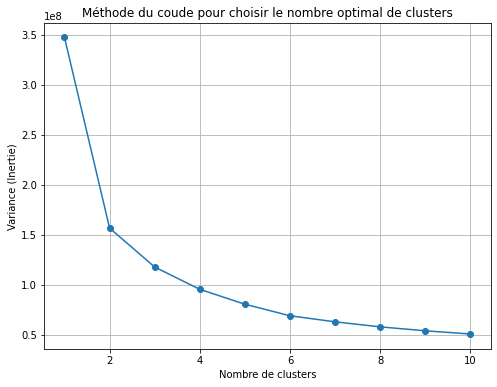

In [ ]:
def find_optimal_clusters(data, max_clusters=10):
    distortions = []  # Liste pour stocker les valeurs de distorsion (variance)
    
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, init='random', n_init='auto')
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)  # Inertie du modèle (mesure de la variance)

    # Tracer le graphique de la variance en fonction du nombre de clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Méthode du coude pour choisir le nombre optimal de clusters')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Variance (Inertie)')
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
data = df_num
find_optimal_clusters(data, max_clusters=10)

In [601]:
from sklearn.cluster import KMeans

n_clusters = NBR_CLUSTER
# Sélectionnez les caractéristiques à utiliser dans le clustering
selected_features = df_num 

kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='random', n_init='auto')
kmeans.fit(selected_features)

df['Cluster'] = kmeans.labels_

In [618]:
df.columns

Index(['date', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'commentaire_annulation',
       'nb_train_depart_retard', 'retard_moyen_depart',
       'retard_moyen_tous_trains_depart', 'commentaire_retards_depart',
       'nb_train_retard_arrivee', 'retard_moyen_arrivee',
       'retard_moyen_tous_trains_arrivee', 'commentaires_retard_arrivee',
       'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
       'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
       'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
       'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
       'prct_cause_prise_en_charge_voyageurs', 'mois', 'annee', 'Cluster'],
      dtype='object')

In [616]:
df.groupby(['gare_depart', 'gare_arrivee']).Cluster.unique()

gare_depart          gare_arrivee        
AIX EN PROVENCE TGV  PARIS LYON                 [3, 0, 2]
ANGERS SAINT LAUD    PARIS MONTPARNASSE      [3, 0, 2, 1]
ANGOULEME            PARIS MONTPARNASSE         [0, 2, 3]
ANNECY               PARIS LYON                    [0, 2]
ARRAS                PARIS NORD                 [0, 3, 2]
                                                 ...     
TOURCOING            MARSEILLE ST CHARLES             [2]
TOURS                PARIS MONTPARNASSE            [0, 2]
VALENCE ALIXAN TGV   PARIS LYON              [0, 3, 2, 1]
VANNES               PARIS MONTPARNASSE            [0, 2]
ZURICH               PARIS LYON                    [2, 0]
Name: Cluster, Length: 130, dtype: object

## Un modèle par cluster

In [576]:
## On divise le dataset en 4 clusters

n_clusters = NBR_CLUSTERS 
grouped = df.groupby('Cluster')
list_cluster_df = []
for category, group in grouped:
    print(f'Cluster {category}')
    list_cluster_df.append(group)
    

# On une random forest à chacun des clusters

score = []

for df in list_cluster_df:

    X = df[['annee', 'mois', 'duree_moyenne']]
    y = df['retard_moyen_arrivee']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    score.append([mse, X_test.shape[0]])
    print(f'Mean Squared Error (MSE): {mse}')

nbr_total = 0
for s in score :
    nbr_total+=s[1]
s_mean = 0
for s in score:
    s_mean += s[0]*s[1]/nbr_total

s_mean

Mean Squared Error (MSE): 131.6734375901805
Mean Squared Error (MSE): 58.67010215524787
Mean Squared Error (MSE): 279.18195826689055
Mean Squared Error (MSE): 62.8345946799249


157.84624011054782

In [587]:
df.columns

Index(['date', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'commentaire_annulation',
       'nb_train_depart_retard', 'retard_moyen_depart',
       'retard_moyen_tous_trains_depart', 'commentaire_retards_depart',
       'nb_train_retard_arrivee', 'retard_moyen_arrivee',
       'retard_moyen_tous_trains_arrivee', 'commentaires_retard_arrivee',
       'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
       'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
       'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
       'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
       'prct_cause_prise_en_charge_voyageurs', 'mois', 'annee', 'Cluster'],
      dtype='object')

## TSNE

In [481]:
df=df_init

list_X_numeric = ['annee','mois','duree_moyenne']

### Les Y à prédire

# Les Causes en %
list_prct_cause = ['prct_cause_externe',
'prct_cause_infra',
'prct_cause_gestion_trafic',
'prct_cause_materiel_roulant',
'prct_cause_gestion_gare',
'prct_cause_prise_en_charge_voyageurs']

# La Durée du retard
list_retard = ['retard_moyen_tous_trains_arrivee',
'retard_moyen_depart',
'retard_moyen_trains_retard_sup15',
'retard_moyen_arrivee']
#,'retard_moyen_tous_tests_depart']

# Le nombre de test en retard
list_nbr_test_en_retard = [
'nb_train_prevu',
'nb_annulation',
'nb_train_depart_retard',
'nb_train_retard_arrivee',
'nb_train_retard_sup_15',
'nb_train_retard_sup_30',
'nb_train_retard_sup_60']

feats_numeric = list_X_numeric+list_retard+list_nbr_test_en_retard+list_prct_cause

df_num = df[feats_numeric]
categories = ['service', 'gare_depart', 'gare_arrivee']
df_categ = df[categories]
df_com = df[['commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee']]
df_com = df_com.drop(columns=['commentaire_annulation', 'commentaire_retards_depart'])
df_com = df_com['commentaires_retard_arrivee'].fillna(0).apply(lambda x: 0 if x==0 else 1)
df_num = pd.concat([df_num, df_com], axis=1)
if df_num.select_dtypes(exclude=['number']).empty:
    print("df_num ne contient que des valeurs numériques\n")
print("df_categ")
df_categ.iloc[:2]

df_num ne contient que des valeurs numériques

df_categ


,service,gare_depart,gare_arrivee
0,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE
1,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE


In [497]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import mpld3

df_tsne = df[categories + feats_numeric].dropna()
X = df_tsne.select_dtypes(include='number')

# Mettre à l'échelle (normaliser) les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer t-SNE sur les données mises à l'échelle
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Créer un DataFrame avec les résultats t-SNE
df_tsne = pd.DataFrame(data=X_tsne, columns=["Dimension 1", "Dimension 2"])

# Ajouter une colonne au DataFrame original pour les catégories
df_tsne[['service', 'gare_depart', 'gare_arrivee']] = df[['service', 'gare_depart', 'gare_arrivee']]  # Remplacez "Categorie" par le nom de votre colonne de catégories

# Créer un graphique interactif avec Matplotlib
fig, ax = plt.subplots()

scatter = ax.scatter(df_tsne["Dimension 1"], df_tsne["Dimension 2"])
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(df_tsne[['service', 'gare_depart', 'gare_arrivee']]))



KeyboardInterrupt: 

In [498]:
mpld3.plugins.connect(fig, tooltip)

plt.title("t-SNE Plot with Category Labels (Scaled Data)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
mpld3.display()

### Analyse de données

In [230]:
df.gare_arrivee.value_counts()
#PARIS LYON                        1649
#PARIS MONTPARNASSE                1056
#LYON PART DIEU                     396
#PARIS EST                          396
#MARSEILLE ST CHARLES               322
#PARIS NORD                         264
#LILLE                              198
big_gare_liste = ["PARIS LYON","PARIS MONTPARNASSE", "LYON PART DIEU", "PARIS EST", "MARSEILLE ST CHARLES", "PARIS NORD", "LILLE"]
df_f = df[df.gare_arrivee.isin(big_gare_liste)]
df_ff = df_f[df_f.gare_depart.isin(big_gare_liste)]

In [231]:

causes_columns = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
                   'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']
df = df_ff.groupby('gare_depart')[causes_columns].mean()

df.reset_index(inplace=True)

KeyError: "Columns not found: 'prct_cause_externe', 'prct_cause_gestion_gare', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_infra', 'prct_cause_prise_en_charge_voyageurs'"

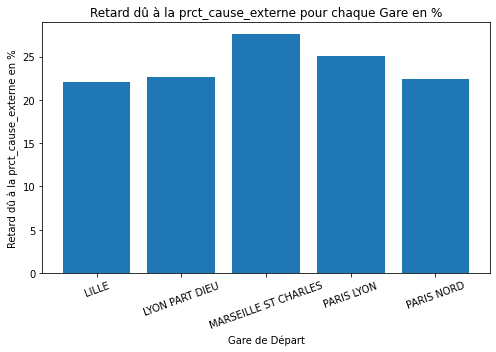

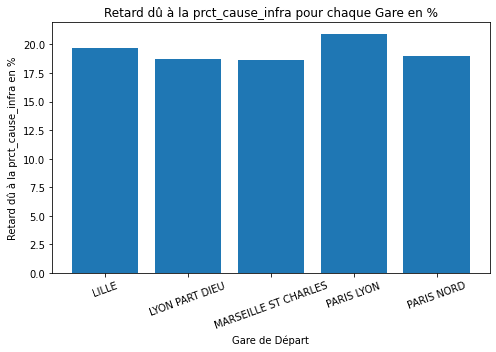

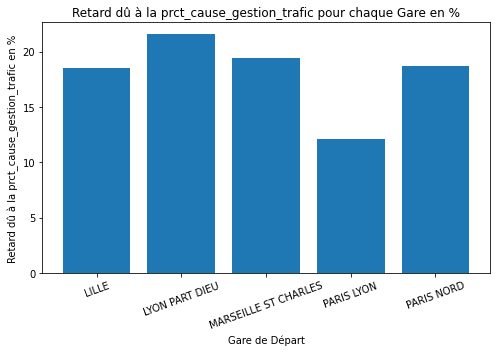

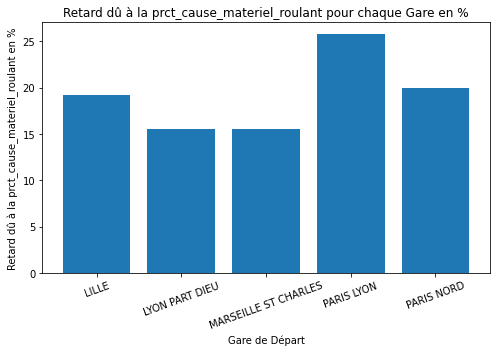

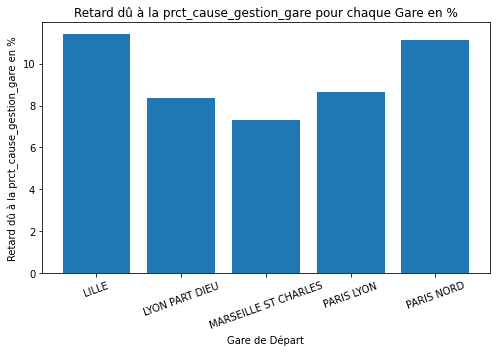

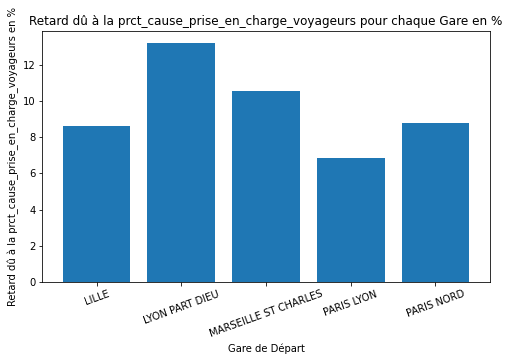

In [ ]:
for cause in causes_columns:
    
    df_plot = df[['gare_depart', cause]]

    # Créez le graphique en barres
    plt.figure(figsize=(7, 5))  # Réglez la taille du graphique
    plt.bar(df_plot['gare_depart'], df_plot[cause])
    plt.xlabel('Gare de Départ')
    plt.ylabel('Retard dû à la '+ cause + ' en %')
    plt.title('Retard dû à la ' + cause + ' pour chaque Gare' + ' en %')
    plt.xticks(rotation=20)  # Faites pivoter les étiquettes d'axe X pour une meilleure lisibilité
    plt.tight_layout()

    # Affichez le graphique
    plt.show()

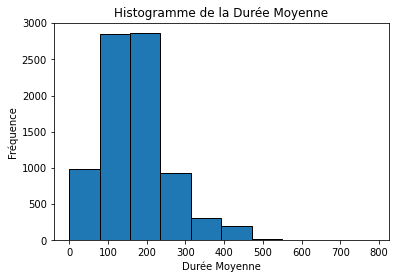

In [18]:

df_f["duree_moyenne"].plot(kind="hist", bins=10, edgecolor="black")

# Vous pouvez personnaliser l'histogramme en ajoutant des labels et un titre
plt.xlabel("Durée Moyenne")
plt.ylabel("Fréquence")
plt.title("Histogramme de la Durée Moyenne")

# Afficher l'histogramme
plt.show()
